In [103]:
%load_ext autoreload
%autoreload 2

import os
import sys

notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))
print(f"notebook_dir: {notebook_dir}")
print(f"Calculated project_root: {project_root}")
print(f"Current sys.path (before modification): {sys.path}")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
notebook_dir: d:\02_Projects\Dev\ReflectoLearn\notebooks
Calculated project_root: d:\02_Projects\Dev\ReflectoLearn
Current sys.path (before modification): ['d:\\02_Projects\\Dev\\ReflectoLearn', 'C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none\\python312.zip', 'C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none\\DLLs', 'C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none\\Lib', 'C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none', 'd:\\02_Projects\\Dev\\ReflectoLearn\\.venv', '', 'd:\\02_Projects\\Dev\\ReflectoLearn\\.venv\\Lib\\site-packages', 'D:\\02_Projects\\Dev\\ReflectoLearn\\src', 'd:\\02_Projects\\Dev\\ReflectoLearn\\.venv\\Lib\\site-packages\\win32', 'd:\\02_Projects\\Dev\\ReflectoLearn\\.venv\\Lib\\site-packages\\win32\\lib', 'd:\\02_Projects\\Dev\\ReflectoL

In [104]:
import matplotlib.pyplot as plt
import numpy as np

from reflectolearn.processing.fitting import (
    estimate_thc,
    func_gauss,
    func_gauss3_with_noise,
    func_noise,
    preprocess_xrr,
    tth2qz_by_energy,
    xrr_fft,
)
from reflectolearn.processing.preprocess import remove_q4_decay
from reflectolearn.processing.simulate import add_xrr_noise, make_multifilm


In [105]:
from scipy.optimize import curve_fit

from reflectolearn.math_utils import apply_poisson_noise, get_background_noise


def multi_gaussian_fitting(x_fit, y_fit, p0):
    # ----------------------- Fit -----------------------
    bounds = (0, np.inf)
    popt, pcov = curve_fit(func_gauss3_with_noise, x_fit, y_fit, p0=p0, bounds=bounds)

    return popt, pcov


def add_noise(R):
    N = len(R)
    R_poisson = apply_poisson_noise(R, s=10 ** 9)
    uniform_noise = 1 + np.random.uniform(-0.1, 0.1, N)
    background_noise = get_background_noise(N, -8, -6)
    curve_scaling = np.random.uniform(0.99, 1.01)
    return R_poisson * uniform_noise * curve_scaling + background_noise


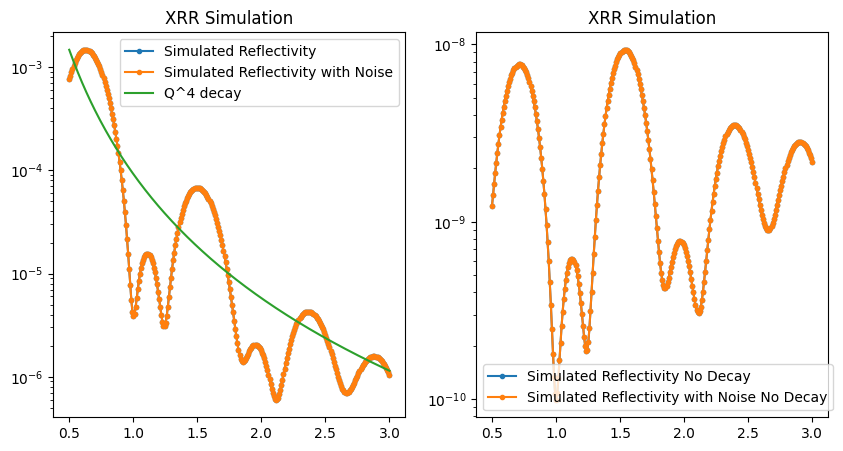

In [106]:
# -----------------------
# 1. 데이터 생성
# -----------------------
beam_energy = 8.04751  # keV
tth = np.linspace(0.5, 3, 300)  # rad
q = tth2qz_by_energy(tth, beam_energy)

# 2층 박막 시뮬레이션 (기판 + 2개 필름)
data = make_multifilm(2, q, add_noise=False)
R = data["R"]
# R_noise = add_noise(R)
R_noise = R.copy()

R_no_q_decay = remove_q4_decay(q, R)
R_noise_no_q_decay = remove_q4_decay(q, R_noise)
decay = 1 / remove_q4_decay(q, np.full_like(q, 1))
decay = decay / decay[0] * R.max()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].semilogy(tth, R, ".-", label="Simulated Reflectivity")
ax[0].semilogy(tth, R_noise, ".-", label="Simulated Reflectivity with Noise")
ax[0].semilogy(tth, decay, "-", label="Q^4 decay")
ax[0].set_title("XRR Simulation")
ax[0].legend()

ax[1].semilogy(tth, R_no_q_decay, ".-", label="Simulated Reflectivity No Decay")
ax[1].semilogy(tth, R_noise_no_q_decay, ".-", label="Simulated Reflectivity with Noise No Decay")
ax[1].set_title("XRR Simulation")
ax[1].legend()

plt.show()

Estimated critical q: 0.6254


D:\02_Projects\Dev\ReflectoLearn\src\reflectolearn\processing\fitting.py:76: RuntimeWarning: invalid value encountered in sqrt
  s_cor = 2 * np.sqrt(


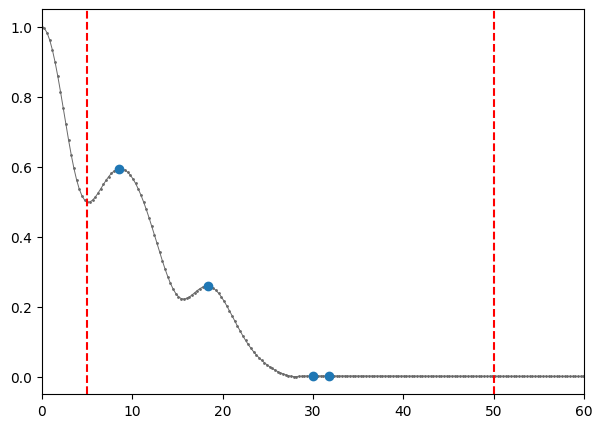

In [107]:
from scipy.signal import argrelextrema

x_upper_bound = 50

crit_q = estimate_thc(tth, R_noise)
print(f"Estimated critical q: {crit_q:.4f}")

# FFT
dat = np.stack([tth, R_noise], axis=1)
xproc, yproc = preprocess_xrr(dat, crit_q)
x_fft, y_fft = xrr_fft(xproc, yproc, window=2, n=10000)
y_fft_norm = y_fft / y_fft[0]

idx_local_max = argrelextrema(y_fft_norm[x_fft < x_upper_bound], np.greater)

y_diff = np.diff(y_fft_norm)
# First increasing index
under_bound_index = np.where(y_diff >= 0)[0][0]
x_under_bound = x_fft[under_bound_index]
upper_bound_index = np.where(x_fft > x_upper_bound)[0][0]

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(7, 5))
ax.plot(x_fft, y_fft_norm, "o-", ms=1, lw=0.7, color="dimgrey", label="FFT data")
ax.plot(x_fft[idx_local_max], y_fft_norm[idx_local_max], "o", label="local max")
ax.axvline(x=x_fft[under_bound_index], color='r', linestyle='--')
ax.axvline(x=x_upper_bound, color='r', linestyle='--')
ax.set_xlim(0, x_upper_bound*1.2)
plt.show()

17 169
Initial guess:
[('a1', 0.2), ('w1', 0.3), ('a2', 0.2), ('pmax2', np.float64(9.48988233001537)), ('w2', 0.3), ('a3', 0.2), ('pmax3', np.float64(19.27632348284372)), ('w3', 0.3), ('amp', 1), ('ex', 2), ('z0', 0.001)]
>>> Multi-Gaussian fit results
- G1: amp=0.07, pos≈11.98 Å, w=4.88
- G2: amp=0.47, pos≈7.14 Å, w=13.19
- G3: amp=0.17, pos≈19.12 Å, w=4.67
- Noise: amp=7.88e-01, exp=1.04, offset=2.01e-41


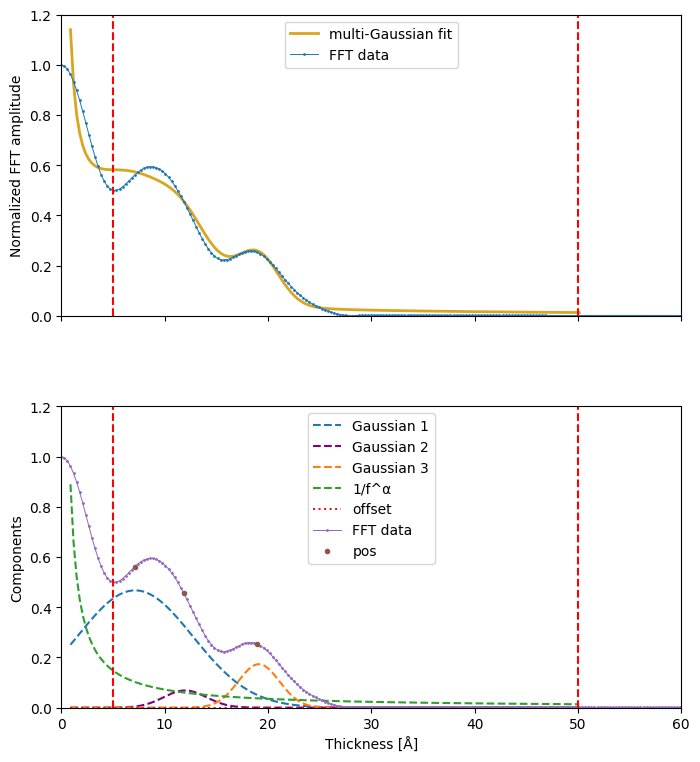

In [108]:
print(under_bound_index, upper_bound_index)

# fitting range
# mask = (x_fft < x_upper_bound) & (x_fft > under_bound_index)
x_fit, y_fit = x_fft[3: upper_bound_index + 1], y_fft_norm[3: upper_bound_index + 1]

params: list[str]= ["a1", "w1", "a2", "pmax2", "w2", "a3", "pmax3", "w3", "amp", "ex", "z0"]
# local maxima들의 인덱스와 값
y_local = y_fit[idx_local_max]
x_local = x_fit[idx_local_max]

# 값이 큰 상위 2개 인덱스 추출
top2_indices = np.argsort(y_local)[-2:]          # 상위 2개 (y 값 기준)
top2_x = x_local[top2_indices]                   # 그 두 점의 x 위치

# 왼쪽/오른쪽 순서 정렬
top2_sorted = np.sort(top2_x)

# 결과 할당
pmax2, pmax3 = top2_sorted[0], top2_sorted[1]

p0: list[float] = [0.2, 0.3, 0.2, pmax2, 0.3, 0.2, pmax3, 0.3, 1, 2, 0.001]
print(f"Initial guess:\n{list(zip(params, p0, strict=True))}")
popt, pcov = multi_gaussian_fitting(x_fit, y_fit, p0)


pos1 = popt[6]-popt[3]
pos2 = popt[3]
pos3 = popt[6]
# ----------------------- Report -----------------------
print(">>> Multi-Gaussian fit results")
print(f"- G1: amp={popt[0]:.2f}, pos≈{pos1:.2f} Å, w={popt[1]:.2f}")
print(f"- G2: amp={popt[2]:.2f}, pos≈{pos2:.2f} Å, w={popt[4]:.2f}")
print(f"- G3: amp={popt[5]:.2f}, pos≈{pos3:.2f} Å, w={popt[7]:.2f}")
print(f"- Noise: amp={popt[8]:.2e}, exp={popt[9]:.2f}, offset={popt[10]:.2e}")

# ----------------------- Plot -----------------------
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 9))

# (상단: 전체 fit vs 데이터)
ax[0].plot(x_fit, func_gauss3_with_noise(x_fit, *popt), "-", color="goldenrod", lw=2, label="multi-Gaussian fit")
ax[0].plot(x_fft, y_fft_norm, "o-", ms=1, lw=0.7, label="FFT data")
ax[0].axvline(x=x_under_bound, color='r', linestyle='--')
ax[0].axvline(x=x_upper_bound, color='r', linestyle='--')
ax[0].set_ylabel("Normalized FFT amplitude")
ax[0].legend()

# (하단: component 분리 보기)
ax[1].plot(x_fit, func_gauss(x_fit, *popt[2:5]), "--", label="Gaussian 1")
ax[1].plot(x_fit, func_gauss(x_fit, popt[0], popt[6] - popt[3], popt[1]), "--", color="purple", label="Gaussian 2")
ax[1].plot(x_fit, func_gauss(x_fit, *popt[5:8]), "--", label="Gaussian 3")
ax[1].plot(x_fit, func_noise(x_fit, *popt[8:10]), "--", label="1/f^α")
ax[1].plot(x_fit, np.ones_like(x_fit)*popt[10], ":", label="offset")
ax[1].plot(x_fft, y_fft_norm, "o-", ms=1, lw=0.7, label="FFT data")
ax[1].axvline(x=x_under_bound, color='r', linestyle='--')
ax[1].axvline(x=x_upper_bound, color='r', linestyle='--')
positions = [pos1, pos2, pos3]
idxs = [np.argmin(np.abs(x_fit - pos)) for pos in positions]
ax[1].plot(x_fit[idxs], y_fit[idxs], ".", label="pos")

ax[1].set_xlabel("Thickness [Å]")
ax[1].set_ylabel("Components")
ax[1].legend()

ax[0].set_xlim(0, x_upper_bound*1.2)
ax[1].set_xlim(0, x_upper_bound*1.2)
ax[0].set_ylim(0, 1.2)
ax[1].set_ylim(0, 1.2)

fig.subplots_adjust(hspace=0.3)
plt.show()